In [1]:
# Standard Machine Learning Imports
import pandas as pd 
# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

Dataset Name: Wine Quality 

Date: 9/26/2020 

Feaures:
Input variables (based on physicochemical tests): 

1 - fixed acidity 

2 - volatile acidity 

3 - citric acid

4 - residual sugar

5 - chlorides

6 - free sulfur dioxide

7 - total sulfur dioxide

8 - density

9 - pH

10 - sulphates

11 - alcohol

Output variable (based on sensory data):

12 - quality (score between 0 and 10)

Algorithm: Gaussian Naive Bayes

In [76]:
# Import the Data to be used
df = pd.read_csv("winequality-white.csv", delimiter=';')
df.append(pd.read_csv('winequality-red.csv', delimiter=';'))

# Print out the head of the dataframe
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [77]:
# Check out the range of the "Quality" Column 
classes = np.unique(df['quality'], return_counts = True)
print("Classes: ", classes[0], " Class count: ", len(classes[0]))

Classes:  [3 4 5 6 7 8 9]  Class count:  7


In [78]:
# Number of Rows in the Dataset
N = len(df)
print("Number of Rows: ", N)

Number of Rows:  4898


For Naive Bayes we need to get the class prior probabilities 

Formula link: https://www.geeksforgeeks.org/naive-bayes-classifiers/

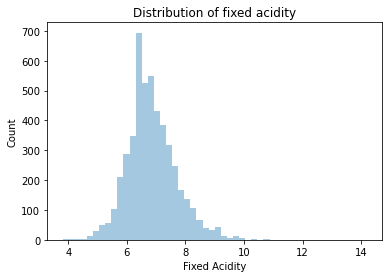

In [79]:
sns.distplot(df['fixed acidity'], kde=0)
plt.title("Distribution of fixed acidity")
plt.xlabel("Fixed Acidity")
plt.ylabel("Count")
plt.show()

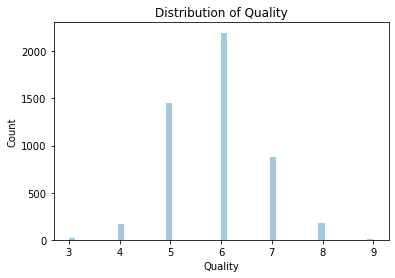

In [80]:
sns.distplot(df['quality'], kde=0)
plt.title("Distribution of Quality")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()

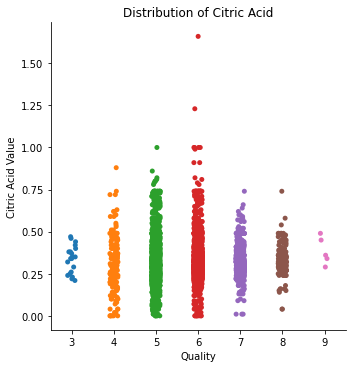

In [81]:
sns.catplot(x='quality', y='citric acid', data=df)
plt.title("Distribution of Citric Acid")
plt.xlabel("Quality")
plt.ylabel("Citric Acid Value")
plt.show()

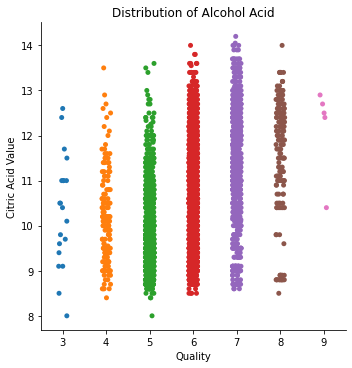

In [82]:
sns.catplot(x='quality',y='alcohol', data=df)
plt.title("Distribution of Alcohol Acid")
plt.xlabel("Quality")
plt.ylabel("Citric Acid Value")
plt.show()

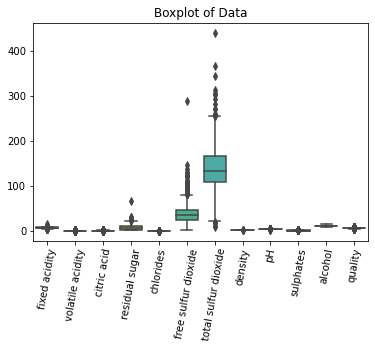

In [83]:
sns.boxplot(data=df)
plt.title("Boxplot of Data")
plt.xticks(rotation=80)
plt.show()

In [84]:
# Standardize the Numerical Values
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

target_col = 'quality'
feature_columns = [i for i in df.columns if i != target_col]

df[feature_columns] = scaler.fit_transform(df[feature_columns])

In [85]:
class Gaussian_NB_v1():
    
    def __init__(self, df, target_column):
        '''
        Docstring:
        
        This Class is to be used for Gaussian Naive Bayes classification
        
        Parameters:
        
        df - Pandas Dataframe   
        target_column - Name of the Target Column
        '''
        import numpy as np 
        import pandas as pd
        
        self.df = df
        
        # Target Column Name in DataFrame
        self.target_column = target_column
        # Feature Column List
        self.feature_columns = [col for col in self.df.columns if col != self.target_column]
        # Unique Values of each category
        self.classes = list(np.unique(df[self.target_column]))
        
        # Length of the DataFrame
        self.N = len(self.df)    
        
        # Prior Probabilities to be used in training
        self.priors = self.get_priors()
        # Mean and Standard Deviations to be used in the Model
        self.column_mean_std = self.get_column_mean_std()
        
    def get_priors(self):
        # Algorithm to put prior probabilities into a python dictionary
        self.unique_values_with_counts = np.unique(self.df[self.target_column], return_counts=True)
        priors = {}
        for cls, count in zip(*self.unique_values_with_counts):
            priors[cls] = count/self.N
        return priors
    
    def get_column_mean_std(self):
        # Dictionary for holding mean and std of the data seperated by column
        # column_info = {class1: {column1:{'mean':mu, 'std':sigma}...} ...}
        column_info = {}
        # Loop through the classes
        for cls in self.classes:
            column_info[cls] = {}
            # Break up the Data by the class we are looping over
            cls_df = self.df[self.df[self.target_column] == cls]
            # Go through each column to input the mean/std
            for col in self.feature_columns:
                mean_std = {'mean': cls_df[col].mean(), 'std': cls_df[col].std()}
                column_info[cls][col] = mean_std
        return column_info
    
    def predict(self,X,y):
        count_correct=0
        import operator
        assert isinstance(y, pd.Series)            
        assert set(X.columns) == set(self.feature_columns)
        
        # Start a prediction list
        predictions=[]
        # Start a dictionary of propabilites for each class
        class_log_proba = {} 
        # Go through each row 
        # Here we sum up the probabilites from the classes
        for index, row in X.iterrows():
            prediction = None
            # Loop through each class
            for cls in self.classes:
                # First add the prior probability
                cls_proba = np.log(self.priors[cls])
                for col in X.columns:
                    # Get the mean for each feature
                    m = self.column_mean_std[cls][col]['mean']
                    # Get the std for each feature
                    s = self.column_mean_std[cls][col]['std']
                    # Add the likelihood from each feature to the prior probability
                    cls_proba += np.log(self.gaussian(row[col],m,s))
                # Input a proabbility for each unique target value
                class_log_proba[cls] = cls_proba
                
            # The prediction is the max probability from each class
            prediction = max(class_log_proba.items(), key=operator.itemgetter(1))[0]
            # Append the prediction for this vector into the predictions list
            predictions.append(prediction)
        # Loop through targets and predictions for accuracy
        for target,prediction in zip(y,predictions):
            if target==prediction:
                count_correct+=1
        return count_correct/self.N
    
    def gaussian(self,x,mean,std):
        # Standard Gaussian Probability
        exponent = np.exp(-((x-mean)**2 / (2 * std**2 )))
        return (1 / (np.sqrt(2 * np.pi) * std)) * exponent
                
        

In [86]:
# Split the Data into train and test sets
from sklearn.model_selection import train_test_split
features = df.drop(['quality'],axis=1)
targets = df['quality']
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.5)
X_train['quality'] = y_train.copy()
nb = Gaussian_NB_v1(X_train,'quality')
nb.predict(X_test, y_test)
# nb.predict(X_train, y_train)

<ipython-input-86-c0e230f98dcc>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['quality'] = y_train.copy()


0.4430379746835443

Accuracy Score: 44%

In [89]:
from sklearn.naive_bayes import GaussianNB
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.5)
clf = GaussianNB()
clf.fit(X_train, y_train)
print("Sklearn Score: ",clf.score(X_test,y_test))

Sklearn Score:  0.44099632503062475


This was a Bad Model to use for this Type of Dataset